Define input data:

In [2]:
import numpy as np

x = np.linspace(0, 2, 5)
y = np.exp(x)

# Interpolation with polynomials

In [3]:
# Define polynomial utilities (1D, square matrix)
import numpy as np
import sympy

def get_polynomial_matrix(interpolation_points: np.ndarray) -> np.ndarray:
    n_rows = n_cols = interpolation_points.shape[0]
    matrix = np.zeros(shape = (n_rows, n_cols))
    for col_index in range(n_cols):
        matrix[:, col_index] = interpolation_points ** col_index
    return matrix

def get_polynomial_interpolant(interpolation_points: np.ndarray, 
                               target_points: np.ndarray) -> sympy.Poly:
    matrix = get_polynomial_matrix(interpolation_points)
    coefs = np.linalg.solve(matrix, target_points)
    # coefs = np.matmul(np.linalg.inv(matrix), target_points) # WRONG APPROACH!
    return sympy.Poly.from_list(np.flip(coefs), sympy.Symbol('x'))

In [4]:
# Get coefficients of polynomial interpolation
matrix = get_polynomial_matrix(x)
explicit_coefficients = np.linalg.solve(matrix, y) # a0, a1, a2, ..., aN
explicit_coefficients = np.flip(explicit_coefficients) # aN, ..., a2, a1, a0
explicit_coefficients

array([0.11807047, 0.00979845, 0.62035757, 0.97005533, 1.        ])

# Interpolation with variational model

In [5]:
import torch

In [6]:
# Polynomial parameters
alphas = torch.nn.Parameter(torch.randn(5))
alphas

Parameter containing:
tensor([-0.2040,  1.1328, -0.6070,  1.6419,  0.8227], requires_grad=True)

In [7]:
x_torch = torch.tensor(x)
y_torch = torch.exp(x_torch)
print(x, y)

[0.  0.5 1.  1.5 2. ] [1.         1.64872127 2.71828183 4.48168907 7.3890561 ]


In [8]:
def create_polynomial_vector(x):
    # Create a vector [x^4, x^3, x^2, x^1, x^0]
    powers = torch.arange(4, -1, -1, dtype=torch.float32)
    polynomial_vector = x ** powers

    return polynomial_vector

In [9]:
# num_iterations = 15000
optimizer = torch.optim.SGD([alphas], lr=1e-5)
loss_list = []
alphas_progress = torch.zeros(1, 5)

In [25]:
abv = torch.tensor(0., requires_grad = False)
for k in range(5):
    abv += torch.square(torch.sum(torch.mul(alphas, create_polynomial_vector(x[k]))) - y[k])
abv = torch.sum(abv) / 5

In [26]:
abb = torch.tensor(0., requires_grad = False)
for k in range(5):
    abb += torch.square(torch.sum(torch.mul(alphas, create_polynomial_vector(x[k]))) - y[k])
abb = abb / 5

In [27]:
print(abv, abb)

tensor(0.0007, grad_fn=<DivBackward0>) tensor(0.0007, grad_fn=<DivBackward0>)


In [10]:
it = 1
while True:
    # Compute loss function (MSE)
    z = torch.tensor(0., requires_grad = False)
    for k in range(5):
        z += torch.square(torch.sum(torch.mul(alphas, create_polynomial_vector(x[k]))) - y[k]) # SE
    z = z / 5 # MSE

    # Store loss and alphas
    loss_list += [z.item()]
    alphas_progress = torch.cat((alphas_progress, torch.zeros(1, 5)))
    alphas_progress[-1, :] = alphas

    # Update parameters
    z.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f'{it} loss: {loss_list[-1]}', end='\r')
    if loss_list[-1] < 1e-7:
        break
    elif it % 600000 == 0:
        if int(input()) == 0:
            break
    it = it + 1
        

In [11]:
alphas_progress.shape

torch.Size([600001, 5])

0.0001352582243271172


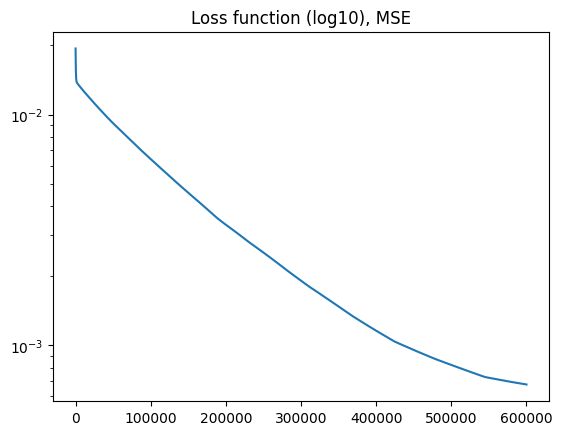

In [21]:
import numpy as np
import matplotlib.pyplot as plt

plt.semilogy(loss_list)
plt.title("Loss function (log10), MSE")
print(loss_list[-1] / 5) # MEAN squared error

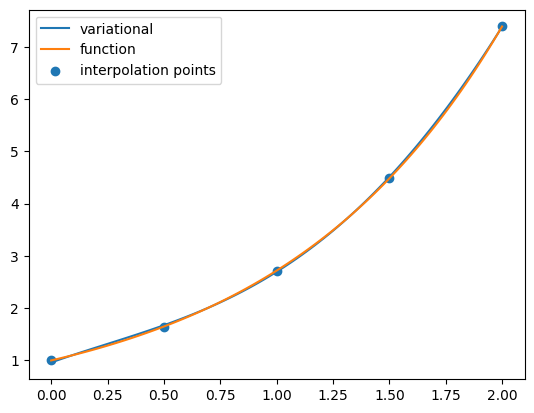

In [13]:
import numpy as np
import matplotlib.pyplot as plt

x_np = np.linspace(0, 2, 100)
a = alphas.detach().numpy()
plt.plot(x_np, a[0] * x_np ** 4 + a[1] * x_np ** 3 + a[2] * x_np ** 2 + a[3] * x_np ** 1 + a[4], label = "variational")
plt.plot(x_np, np.exp(x_np), label = "function")
plt.scatter(x, y, label = "interpolation points")
plt.legend()

In [14]:
alphas

Parameter containing:
tensor([-0.1388,  1.0558, -0.7203,  1.5379,  0.9610], requires_grad=True)

In [15]:
explicit_coefficients

array([0.11807047, 0.00979845, 0.62035757, 0.97005533, 1.        ])

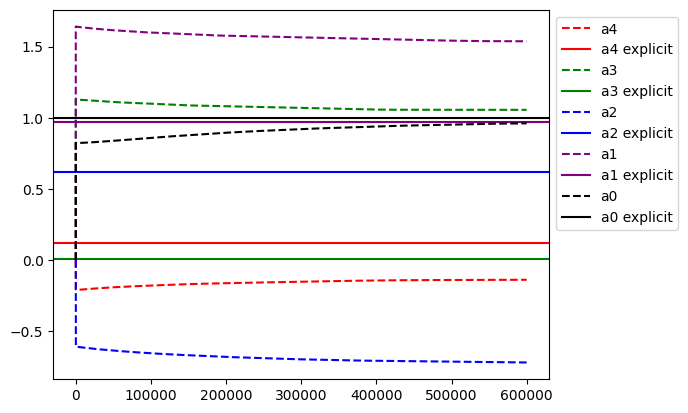

In [20]:
alphas_numpy = alphas_progress.detach().numpy()
plt.plot(alphas_numpy[:, 0], label="a4", color = "red", linestyle='--')
plt.axhline(explicit_coefficients[0], label="a4 explicit", color = "red")
plt.plot(alphas_numpy[:, 1], label="a3", color = "green", linestyle='--')
plt.axhline(explicit_coefficients[1], label="a3 explicit", color = "green")
plt.plot(alphas_numpy[:, 2], label="a2", color = "blue", linestyle='--')
plt.axhline(explicit_coefficients[2], label="a2 explicit", color = "blue")
plt.plot(alphas_numpy[:, 3], label="a1", color = "purple", linestyle='--')
plt.axhline(explicit_coefficients[3], label="a1 explicit", color = "purple")
plt.plot(alphas_numpy[:, 4], label="a0", color = "black", linestyle='--')
plt.axhline(explicit_coefficients[4], label="a0 explicit", color = "black")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

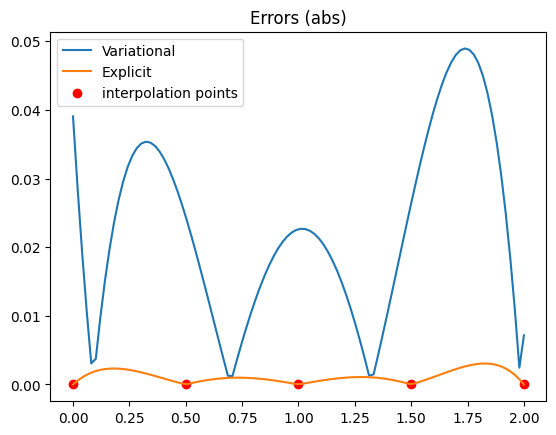

In [19]:
import numpy as np
import matplotlib.pyplot as plt

x_np = np.linspace(0, 2, 100)
a = alphas.detach().numpy()
plt.plot(x_np,np.abs(np.exp(x_np) - (a[0] * x_np ** 4 + a[1] * x_np ** 3 + a[2] * x_np ** 2 + a[3] * x_np ** 1 + a[4])), 
         label = "Variational")
plt.plot(x_np,np.abs(np.exp(x_np) - (explicit_coefficients[0] * x_np ** 4 + explicit_coefficients[1] * x_np ** 3 + explicit_coefficients[2] * x_np ** 2 + explicit_coefficients[3] * x_np ** 1 + explicit_coefficients[4])), 
         label = "Explicit")
plt.scatter(x, 0 * y, label = "interpolation points", color = "red")
plt.title("Errors (abs)")
plt.legend()